# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель работы:** спрогнозировать, уйдёт ли клиент в ближайшее время из банка или нет.

**Ход работы:**
1.  Подготовка данных
2.  Исследование задачи
3.  Борьба с дисбалансом
4.  Тестирование модели

## Подготовка данных

### Обзор данных

Импортируем все необходимые в работе библиотеки и функции.

In [1]:
#импорт библиотек и функций
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle

Откроем и изучим файл с данными.

In [2]:
#сохранение данных в переменной data, вывод первых 5 строк на экран
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Согласно документации и полученным данным, таблица состоит из 10000 объектов, **признаки:**
* `RowNumber` - индекс строки в данных;
* `CustomerId` - уникальный идентификатор клиента;
* `Surname` - фамилия;
* `CreditScore` - кредитный рейтинг;
* `Geography` - страна проживания;
* `Gender` - пол;
* `Age` - возраст;
* `Tenure` - сколько лет человек является клиентом банка;
* `Balance` - баланс на счёте;
* `NumOfProducts` - количество продуктов банка, используемых клиентом;
* `HasCrCard` - наличие кредитной карты;
* `IsActiveMember` - активность клиента;
* `EstimatedSalary` - предполагаемая зарплата;

**целевой признак:**
* `Exited` - факт ухода клиента;

**Выводы:**

1. В столбце `Tenure` присутствуют пропущенные значения.
2. Данные в столбце `Tenure` нужно преобразовать к типу `int`.
3. Неинформативные признаки `RowNumber`, `CustomerId` и `Surname` нужно убрать из таблицы.

### Предобработка данных

1. Пропуски присутствуют только в столбце `Tenure`, оценим количество пропущенных значений.

In [4]:
#доля пропусков в столбце Tenure
len(data[data['Tenure'].isna()]) / len(data)

0.0909

В столбце пропущено примерно 9% значений, рассмотрим распределение значений.

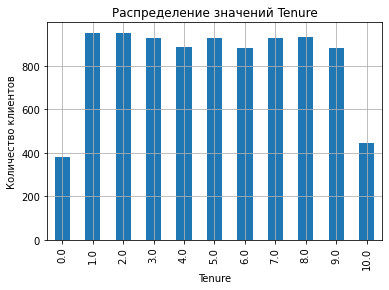

In [5]:
#построение столбчатой диаграммы
data.groupby('Tenure')['Tenure'].count().plot(kind='bar',     
                                              title='Распределение значений Tenure',
                                              xlabel='Tenure',
                                              ylabel='Количество клиентов',
                                              grid=True);

Пропуски могли возникнуть из-за сбоя при выгрузке данных, возможно, это данные о клиентах, которые более 10 лет являются клиентами банка, либо о тех, которые только стали клиентами. 9% данных - слишком много, чтобы просто удалить их, потому заполним пропуски случайным значением от 0 до 10, также преобразуем данные к типу `int`.

In [6]:
#заполнение пропусков случайным значением от 0 до 10
data['Tenure'] = data['Tenure'].fillna(pd.Series(np.random.randint(11, size=len(data))))
#замена типа данных на int
data['Tenure'] = data['Tenure'].astype('int')

2. Уберем признаки, которые не влияют на факт ухода клиента из банка - `RowNumber`, `CustomerId` и `Surname`.

In [8]:
#удаление признаков RowNumber, CustomerId и Surname
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


3. Проверим распределения признаков `CreditScore`, `Age`, `NumOfProucts` на наличие выбросов и аномалий.

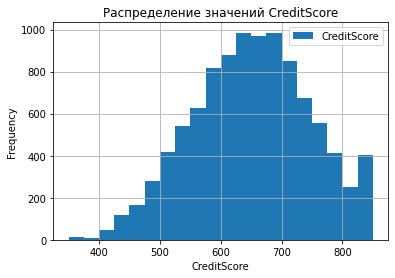

In [9]:
#гистограмма для CreditScore
ax = data.plot(kind='hist',
               y='CreditScore',
               bins=20,
               title='Распределение значений CreditScore',
               grid=True)
ax.set(xlabel='CreditScore');

Значения расположены на отрезке от 350 до 850, что соответствует действительности. В основном, значения кредитного скоринга лежат в отрезке от 0 до 850, а градация такова, что ниже 500 баллов - это низкий рейтинг, средний рейтинг лежит в отрезке от 500 до 600 баллов, хороший рейтинг - это 600-700 баллов, а все, что выше 700 - это очень хороший рейтинг.

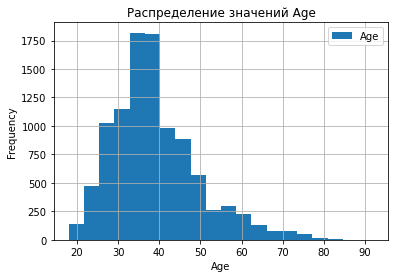

In [12]:
#гистограмма для Age
ax = data.plot(kind='hist',
               y='Age',
               bins=20,
               title='Распределение значений Age',
               grid=True)
ax.set(xlabel='Age');

Значения расположены на отрезке от 18 до 85, что соответствует действительности.

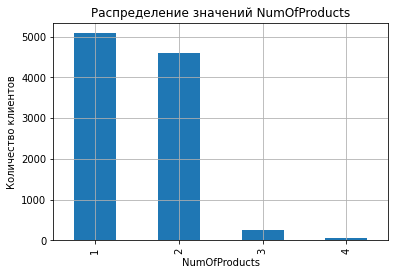

In [13]:
#столбчатая диаграмма для NumOfProducts
data['NumOfProducts'].value_counts().plot(kind='bar',
                                          title='Распределение значений NumOfProducts',
                                          xlabel='NumOfProducts',
                                          ylabel='Количество клиентов',
                                          grid=True);

Для признака NumOfProducts также не наблюдаются аномалии.

4. Рассмотрим целевой признак `Exited`, исследуем на баланс классов.

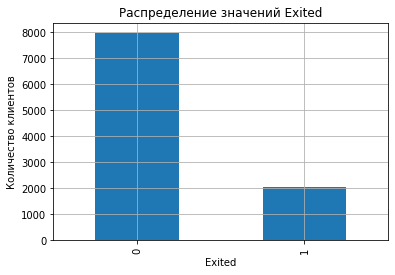

In [14]:
#построение столбчатой диаграммы для целевого признака
data['Exited'].value_counts().plot(kind='bar', 
                                   title='Распределение значений Exited',
                                   xlabel='Exited',
                                   ylabel='Количество клиентов',
                                   grid=True);

Виден дисбаланс классов для целевого признака `Exited`, класс "0" примерно в 4 раза больше класса "1".

5. Преобразуем категориальные признаки в числовые при помощи прямого кодирования.

In [15]:
#преобразование категориальных данных в числовые с помощью One-Hot Encoding
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Разделим данные на обучающую, валидационную и тестовую выборки.

In [16]:
#разделение на признаки и целевой признак
features = data.drop('Exited', axis=1)
target = data['Exited']

#разделение на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.4,
                                                                              random_state=12345,
                                                                              stratify=target) 
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5, 
                                                                            random_state=12345,
                                                                            stratify=target_valid)

#проверка размеров выборок
print(features_train.shape, target_train.shape, '\n',
      features_valid.shape, target_valid.shape, '\n',
      features_test.shape, target_test.shape)

(6000, 11) (6000,) 
 (2000, 11) (2000,) 
 (2000, 11) (2000,)


Приведем числовые признаки к одному масштабу при помощи стандартизации данных.

In [17]:
#признаки для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#стандартизация данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#проверка результата работы стандартизации
features_train.head()

/tmp/ipykernel_93/4193827484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.340634,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.377715,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.027974,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,1.371644,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.377715,0.879129,-0.914708,1,0,0.113236,0,0,0


### Вывод

* Были убраны пропуски в столбце `Tenure`, также тип данных был приведен к `int`;
* Удалены неинформативные признаки `RowNumber`, `CustomerId` и `Surname`;
* `CreditScore`, `Age`, `NumOfProucts` были проверены на наличие аномалий и выбросов;
* Для целевого признака `Exited` был обнаружен существенный дисбаланс классов;
* При помощи прямого кодирования категориальные признаки были приведены к числовым, данные разделены на обучающую, валидационную и тестовую выборки, числовые признаки были приведены к одному масштабу.

## Исследование задачи

Обучим модель без учета дисбаланса классов при помощи дерева решений, случайного леса и логистической регрессии.

### Дерево решений

In [18]:
%%time

best_model_dt = None
best_result = 0
best_depth = 0

#обучаем модель при помощи дерева решений с разным max_depth, ищем лучшую модель
for depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt = model
        best_depth = depth

#вывод параметров лучшей модели
print('max_depth:', best_depth, '\n', 'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 7 
 F1-мера: 0.59
AUC-ROC: 0.82
CPU times: user 440 ms, sys: 6.35 ms, total: 446 ms
Wall time: 474 ms


### Случайный лес

In [20]:
%%time

best_model_rf = None
best_result = 0
best_depth = 0
best_est = 0

#обучаем модель при помощи случайного леса с разными max_depth и n_estimators, 
#ищем лучшую модель
for depth in range(2, 21):
    for est in range(10, 101, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
    
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rf = model
            best_depth = depth
            best_est = est

#вывод параметров лучшей модели
print('max_depth:', best_depth, 
      'n_estimators:', best_est, '\n', 
      'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 12 n_estimators: 40 
 F1-мера: 0.61
AUC-ROC: 0.86
CPU times: user 57.3 s, sys: 291 ms, total: 57.6 s
Wall time: 57.6 s


### Логистическая регрессия

In [21]:
%%time

#обучаем модель при помощи логистической регрессии
model_lr = LogisticRegression(solver='liblinear', random_state=12345)
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('F1-мера:', round(result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

F1-мера: 0.3
AUC-ROC: 0.79
CPU times: user 69.2 ms, sys: 108 ms, total: 177 ms
Wall time: 199 ms


### Вывод

При помощи алгоритмов дерева решений, случайного леса и логистической регрессии были обучены модели без учета дисбаланса классов. Логистическая регрессия дала самые плохие значения F1-меры и AUC-ROC, самые хорошие значения F1-меры и AUC-ROC показали модели, обученные при помощи случайного леса с гиперпараметрами max_depth=18 и n_estimators=30 и при помощи дерева решений с max_depth=7.

## Борьба с дисбалансом

Избавимся от дисбаланса классов при помощи взвешивания классов, увеличения и уменьшения выборки и обучим модель при помощи дерева решений, случайного леса и логистической регрессии.

### Взвешивание классов

* Дерево решений

In [22]:
%%time

best_model_dt_balanced = None
best_result = 0
best_depth = 0

#обучаем модель при помощи дерева решений с разным max_depth, ищем лучшую модель
for depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=depth,
                                   random_state=12345,
                                   class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt_balanced = model
        best_depth = depth

#вывод параметров лучшей модели
print('max_depth:', best_depth, '\n', 'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_dt_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 6 
 F1-мера: 0.58
AUC-ROC: 0.82
CPU times: user 440 ms, sys: 16 ms, total: 456 ms
Wall time: 529 ms


* Случайный лес

In [23]:
%%time

best_model_rf_balanced = None
best_result = 0
best_depth = 0
best_est = 0

#обучаем модель при помощи случайного леса с разными max_depth и n_estimators, 
#ищем лучшую модель
for depth in range(2, 21):
    for est in range(10, 101, 10):
        model = RandomForestClassifier(max_depth=depth, 
                                       n_estimators=est, 
                                       random_state=12345, 
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
    
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rf_balanced = model
            best_depth = depth
            best_est = est

#вывод параметров лучшей модели
print('max_depth:', best_depth, 
      'n_estimators:', best_est, '\n', 
      'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_rf_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 8 n_estimators: 100 
 F1-мера: 0.65
AUC-ROC: 0.87
CPU times: user 57 s, sys: 324 ms, total: 57.3 s
Wall time: 57.4 s


* Логистическая регрессия

In [24]:
%%time

#обучаем модель при помощи логистической регрессии
model_lr_balanced = LogisticRegression(solver='liblinear',
                                       random_state=12345,
                                       class_weight='balanced')
model_lr_balanced.fit(features_train, target_train)
predicted_valid = model_lr_balanced.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('F1-мера:', round(result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = model_lr_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

F1-мера: 0.53
AUC-ROC: 0.79
CPU times: user 70.4 ms, sys: 92.2 ms, total: 163 ms
Wall time: 161 ms


После придания объектам редкого класса большего веса значение F1-меры для лучшей модели дерева решений немного уменьшилось, для случайного леса показатели F1-меры и AUC-ROC заметно улучшились, для логистической регрессии значение F1-меры значительно выросло.

### Увеличение выборки

<AxesSubplot:title={'center':'Проверка баланса классов'}>

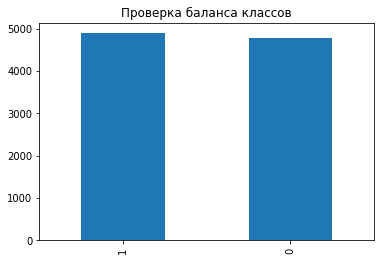

In [25]:
#функция для увеличения выборки в repeat раз
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#проверка баланса классов
target_upsampled.value_counts().plot(kind='bar', title='Проверка баланса классов')

* Дерево решений

In [26]:
%%time

best_model_dt_upsampled = None
best_result = 0
best_depth = 0

#обучаем модель при помощи дерева решений с разным max_depth, ищем лучшую модель
for depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt_upsampled = model
        best_depth = depth

#вывод параметров лучшей модели
print('max_depth:', best_depth, '\n', 'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_dt_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 6 
 F1-мера: 0.58
AUC-ROC: 0.83
CPU times: user 620 ms, sys: 57 µs, total: 620 ms
Wall time: 619 ms


* Случайный лес

In [27]:
%%time

best_model_rf_upsampled = None
best_result = 0
best_depth = 0
best_est = 0

#обучаем модель при помощи случайного леса с разными max_depth и n_estimators, 
#ищем лучшую модель
for depth in range(2, 21):
    for est in range(10, 101, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
    
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rf_upsampled = model
            best_depth = depth
            best_est = est

#вывод параметров лучшей модели
print('max_depth:', best_depth, 
      'n_estimators:', best_est, '\n', 
      'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_rf_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 10 n_estimators: 70 
 F1-мера: 0.65
AUC-ROC: 0.87
CPU times: user 1min 19s, sys: 312 ms, total: 1min 20s
Wall time: 1min 20s


* Логистическая регрессия

In [28]:
%%time

#обучаем модель при помощи логистической регрессии
model_lr_upsampled = LogisticRegression(solver='liblinear', random_state=1234)
model_lr_upsampled.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr_upsampled.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('F1-мера:', round(result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = model_lr_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

F1-мера: 0.53
AUC-ROC: 0.79
CPU times: user 21.4 ms, sys: 95.8 ms, total: 117 ms
Wall time: 88.3 ms


После увеличения выборки значения метрик для дерева решений не изменились, для случайного леса показатели F1-меры и AUC-ROC заметно улучшились, для логистической регрессии значение F1-меры также значительно выросло.

### Уменьшение выборки


<AxesSubplot:title={'center':'Проверка баланса классов'}>

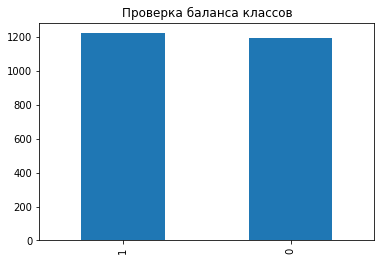

In [29]:
#функция для уменьшения выборки в fraction раз
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#проверка баланса классов
target_downsampled.value_counts().plot(kind='bar', title='Проверка баланса классов')

* Дерево решений

In [30]:
%%time

best_model_dt_downsampled = None
best_result = 0
best_depth = 0

#обучаем модель при помощи дерева решений с разным max_depth, ищем лучшую модель
for depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt_downsampled = model
        best_depth = depth

#вывод параметров лучшей модели
print('max_depth:', best_depth, '\n', 'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_dt_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 6 
 F1-мера: 0.6
AUC-ROC: 0.85
CPU times: user 223 ms, sys: 3.98 ms, total: 226 ms
Wall time: 233 ms


* Случайный лес

In [31]:
%%time

best_model_rf_downsampled = None
best_result = 0
best_depth = 0
best_est = 0

#обучаем модель при помощи случайного леса с разными max_depth и n_estimators, 
#ищем лучшую модель
for depth in range(2, 21):
    for est in range(10, 101, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
    
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rf_downsampled = model
            best_depth = depth
            best_est = est

#вывод параметров лучшей модели
print('max_depth:', best_depth, 
      'n_estimators:', best_est, '\n', 
      'F1-мера:', round(best_result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = best_model_rf_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

max_depth: 7 n_estimators: 30 
 F1-мера: 0.64
AUC-ROC: 0.87
CPU times: user 32.6 s, sys: 148 ms, total: 32.8 s
Wall time: 32.8 s


* Логистическая регрессия

In [32]:
%%time

#обучаем модель при помощи логистической регрессии
model_lr_downsampled = LogisticRegression(solver='liblinear', random_state=1234)
model_lr_downsampled.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_downsampled.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('F1-мера:', round(result, 2))

#предсказываем вероятности классов, считаем auc_roc
probabilities_valid = model_lr_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', round(auc_roc, 2))

F1-мера: 0.53
AUC-ROC: 0.79
CPU times: user 32.3 ms, sys: 24.1 ms, total: 56.4 ms
Wall time: 15.5 ms


После уменьшения выборки показатели F1-меры и AUC-ROC для лучших моделей дерева решений и случайного леса улучшились, для логистической регрессии улучшилось значение F1-меры.

### Вывод

После устранения дисбаланса классов лучших показателей метрик достигли модели случайного леса при max_depth=8 и n_estimators=100 после взвешивания классов и при max_depth=10 и n_estimators=70 после увеличения выборки, после взвешивания классов алгоритм сработал немного быстрее по времени, но проведем финальное тестирования для обеих моделей.

## Тестирование модели

Проведем финальное тестирование лучших моделей.

* Случайный лес после взвешивания классов

In [33]:
#проверка модели на тестовой выборке
predicted_test = best_model_rf_balanced.predict(features_test)

probabilities_test = best_model_rf_balanced.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('F1-мера:', round(f1_score(target_test, predicted_test), 2), '\n', 
      'AUC-ROC:', round(roc_auc_score(target_test, probabilities_one_test), 2))

F1-мера: 0.61 
 AUC-ROC: 0.86


* Случайный лес после увеличения выборки

In [34]:
#проверка модели на тестовой выборке
predicted_test = best_model_rf_upsampled.predict(features_test)

probabilities_test = best_model_rf_upsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('F1-мера:', round(f1_score(target_test, predicted_test), 2), '\n', 
      'AUC-ROC:', round(roc_auc_score(target_test, probabilities_one_test), 2))

F1-мера: 0.6 
 AUC-ROC: 0.85


### Вывод

Лучшие показатели  F1-меры и AUC-ROC показала модель, обученная при помощи случайного леса с гиперпараметрами max_depth=8 и n_estimators=100 после взвешивания классов.

## Общий вывод

В ходе данной работы данные о клиентах "Бета-Банка" были исследованы и подготовлены, были удалены пропуски и признаки, не влияющие на факт ухода клиента из банка, также был исследован баланс классов. Была найдена и протестирована лучшая модель, это модель, обученная при помощи случайного леса с гиперпараметрами max_depth=8 и n_estimators=100 после взвешивания классов, показатели метрик после финального тестирования F1-мера=0.61, AUC-ROC=0.86.